<img style="float: left;" src="images/earth-lab-logo-rgb.png" width="150" height="150" />

# Earth Analytics

<img style="float: left;" src="images/colored-bar.png"/>

### This notebook provides code that allows comparaison of LIDAR Canopy Height Model tree height estimates to insitu tree height measurements.

### Study locations are the low elevation [NEON SJER](https://www.neonscience.org/field-sites/sjer) study area in California and the mid-elevation [NEON SOAP](https://www.neonscience.org/field-sites/soap) study area in California. 

### Design of this notebook:
I decided to write one class that takes care of processing files and computing the analysis.  The class contains three methods.  I elected to write two functions for setting paths and downloading the dataset because these operations seemed to be more specific to this project rather than widely applicable to a generic project.  For creating plots, I decided to write two functions and import them in a single file.  One function plots up scatterplots and the other plots up some maps.  I deemed plotting to be quite seperate from performing the analysis so I decided to seperate them out.
 
### Users of this notebook:   
1. A sample data set from [EarthPy](https://earthpy.readthedocs.io/en/latest/earthpy-data-subsets.html) is downloaded to your local machine.  
2. Change the study_site variable to either sjer or soap study sites.
3. Change the buffer size in meters to adjust the number of lidar pixels to compute stats with.


### Unresolved issues with the Notebook:
1. In plotting.py, line 163.  I want to create a point showing the study site "area of interest".  Python throws a warning suggesting that there are two types of crs: geographics and projected.  I have tried the suggestion to use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation, but this did not work.  I'm leaving it as is because the centroid plot is accurate enough for these purposes.
2. In plotting.py, line 159.  I'm clipping the roads shapefile to the lidar file extent.  Python throws a future warning.  Ignoring it because it is out of my control unless there is an alternate way to clip.
3. In plotting.py, line 188.  I wanted to add a legend to indicate the black lines are roads, but when I include a legend in various permutations, it takes python forever to figure it out and render it.  I've left it off for now.

Code by Tyler Cruickshank (tcruicks@gmail.com)
![Colored Bar](images/colored-bar.png)

In [1]:
import os

import rasterstats as rs
import rioxarray as rxr
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import numpy as np

import seaborn as sns
import matplotlib as plt
import plotting as plot
from set_paths import set_paths
from download_dataset import download_dataset

![Colored Bar](images/colored-bar.png)
### Set Project Plotting styles.
![Colored Bar](images/colored-bar.png)

In [2]:
# Set consistent plotting style for all code cells.
sns.set_style("white")
sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')


#### Here is the class.

In [3]:
class Processing:

    def __init__(self, study_site, lidar_pth, insitu_pth, plots_pth, buf_size):
        """ 
        Sets object attributes.
        
        Attributes:
        -----------
        lidar_pth: str
            Path to the lidar file itself.
        insitu_pth: str
            Path to the insitu tree height data file itself.
        plots_pth: str
            Path to the study sites shapefile.
        buf_size: int
            Size in meters of buffer around each study plot point.
        """
        self.study_site = study_site
        self.lidar_pth = lidar_pth
        self.insitu_pth = insitu_pth
        self.plots_pth = plots_pth
        self.buf_size = buf_size

    def lidar_stats(self, plots_gdf):
        """ 
        Open, clean, compute tree height stats on lidar file.

        Parameters:
        ----------
        plot_gdf: geodataframe
            GDF with buffer geometery.
        Returns:
        -------
        lidar_chm_clean: dataarray
            New lidar file with zeros removed.
        lidar_chm_stats_gdf: geodataframe
            GDF containing lidar stats for buffered study sites.
        """
        # Open lidar file.
        lidar_chm = rxr.open_rasterio(self.lidar_pth, masked=True).squeeze()
        # Clean up the lidar file.
        lidar_chm_clean = lidar_chm.where(lidar_chm > 0, np.nan)
        
        # Compute the mean and max lidar values within the buffer.
        lidar_chm_stats = rs.zonal_stats(
            plots_gdf,
            lidar_chm_clean.values,
            stats=['mean', 'max'],
            affine=lidar_chm_clean.rio.transform(),
            geojson_out=True, nodata=0, copy_properties=True,
        )
        # Stick it in a dataframe.
        lidar_chm_stats_gdf = gpd.GeoDataFrame.from_features(lidar_chm_stats)

        # Rename df columns.
        lidar_chm_stats_gdf.rename(
            columns={'max': 'lidar_max',
                     'mean': 'lidar_mean', 'ID': 'Plot_ID'},
            inplace=True
        )

        return (lidar_chm_clean, lidar_chm_stats_gdf)

    def insitu_stats(self):
        """ 
        Calculates tree height stats fro mobservations.

        Returns:
        -------
        insitu_stem_height_df: geodataframe
            GDF with observed tree height stats.
        """

        insitu_gdf = gpd.read_file(self.insitu_pth)

        # Reduce the columns to only what we need.
        insitu_gdf = (insitu_gdf[
            ["siteid", "sitename", "plotid", "stemheight", "scientificname"]])

        # This solves an oddity.  The 'stemheight' column is not coming out as numeric.
        # We need to change the datatype to a float.  As a float .mean and .max will work.
        insitu_gdf["stemheight"] = pd.to_numeric(
            insitu_gdf["stemheight"], downcast="float")

        # Create a df to include max and mean height.
        insitu_stem_height_df = (insitu_gdf.groupby(
            'plotid')['stemheight'].agg(['max', 'mean']))

        # Rename column names to be more explanatory/
        insitu_stem_height_df.rename(
            columns={"mean": "insitu_mean", "max": "insitu_max"},
            inplace=True
        )

        # The index is plotid but we just want 0 ... 9 ...
        insitu_stem_height_df = insitu_stem_height_df.reset_index()
        insitu_stem_height_df.head()

        return (insitu_stem_height_df)

    def buffer(self):
        """ 
        Creates a buffer around study site point locations.
        Returns:
        -------
        plots_gdf: geodataframe
            GDF containing study site point locations.
        plot_buffer_path: str
            Path to shapefule with buffered geometry.
        """
        # Open sjer plot location file.
        plots_gdf = gpd.read_file(self.plots_pth)
        # reset the geometry to the buffer version.
        plots_gdf.geometry = plots_gdf.geometry.buffer(self.buf_size)

        # Name and location of the buffered insitu measurement sites.

        # Create an output dir for created files.
        output_path = os.path.join(os.getcwd(), 'outputs')
        if not os.path.isdir(output_path):
            os.makedir(output_path)

        plot_buffer_path = os.path.join(output_path, "plot_buffer.shp")
        # Create the buffered file.
        plots_gdf.to_file(plot_buffer_path)

        return (plots_gdf, plot_buffer_path)
    
    def merge(self, lidar_stats_gdf, insitu_stats_gdf):
        """ 
        Merge observation stats df with LIDAR stats df.

        Parameters:
        ----------
        lidar_stats_gdf: geodataframe
            GDF containing lidar tree height stats from buffer zones.
        insitu_stats_gdf: geodataframe
            GDF containing observed tree height stats.

        Returns:
        -------
        all_heights_gdf: geodataframe
            GDF contaiining both lidar and observed tree heights.
        """
        # For the SOAP site, the ID column doesnt math the insitu ID column.
        # The Lidar file column needs 'SOAP' text appended to the ID integer.

        if (self.study_site == 'soap'):
            ss = self.study_site.upper()
            lidar_stats_gdf['Plot_ID'] = ss + lidar_stats_gdf['Plot_ID']

        all_heights_gdf = lidar_stats_gdf.merge(
            insitu_stats_gdf,
            left_on='Plot_ID',
            right_on='plotid')

        return(all_heights_gdf)
    

![Colored Bar](images/colored-bar.png)
### The Main Code Cell.  I've included two main code cells.  One for SJER and one for SOAP.  The user can edit study_site and buffer if desired.
![Colored Bar](images/colored-bar.png)

SJER LIDAR DATA EXISTS.


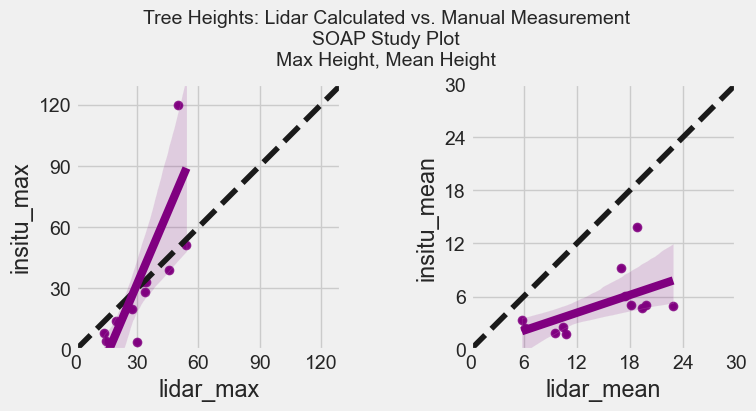

/opt/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/Users/tylercruickshank/earth-analytics/ea-assignments/ea-05-lidar-uncertainty-workflow-tcruicks/plotting.py:176: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoi_point = aoi_reproj_gdf["geometry"].centroid


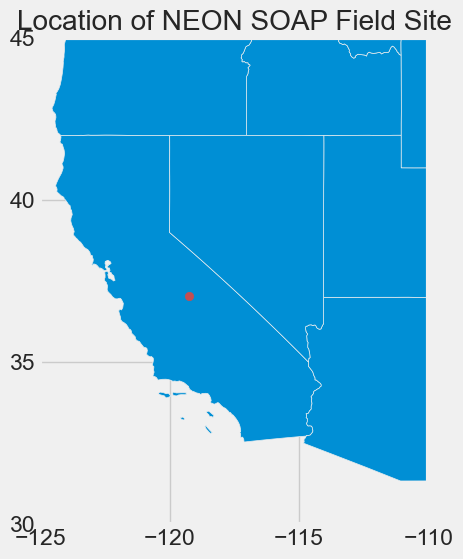

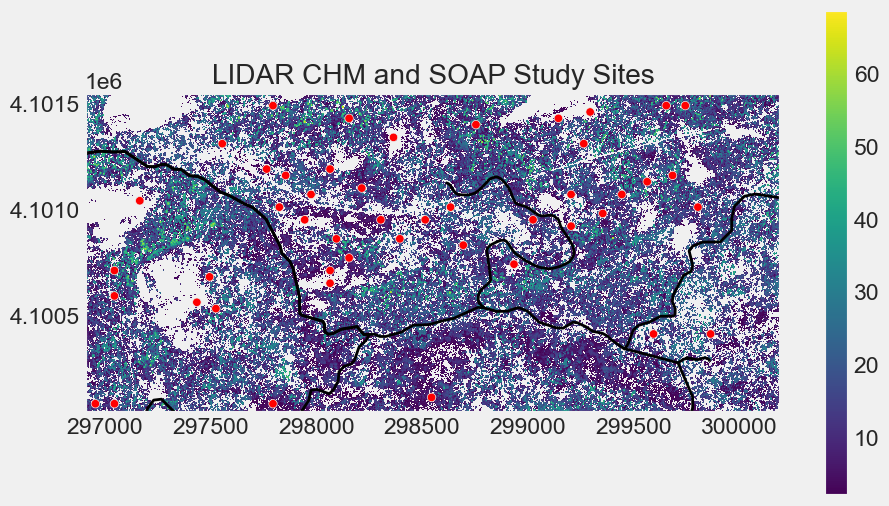

In [4]:
# MAIN Code Cell ---------------------
study_site = 'soap'
buffer = 20
# ------------------------------------

# Set all paths and directories for project.
(home_dir, plots_path, insitu_path,
 lidar_chm_path, output_path, usa_bndry_path,
 states_bndry_path, roads_path,
 sjer_aoi_path) = set_paths(study_site)

# Download dataset for project.
download_dataset(home_dir)

# Create an object out of the class
sjer_analysis = Processing(study_site, lidar_chm_path, insitu_path, plots_path, buffer)

# Call class methods on the class object.

# Create a buffer around study site plot point locations.
(plots_gdf, plot_buffer_path) = sjer_analysis.buffer()
# Compute lidar tree height stats in buffer.
(lidar_chm_clean, lidar_chm_stats_gdf) = sjer_analysis.lidar_stats(plots_gdf)
# Compute tree height stats from insitu observations.
(insitu_stem_height_df) = sjer_analysis.insitu_stats()
# Merge both sets of stats - lidar and insitu.
(tree_height_stats_gdf) = sjer_analysis.merge(lidar_chm_stats_gdf, insitu_stem_height_df)

# Create plots
plot.create_comparison_plots(tree_height_stats_gdf, study_site)

# Quick plot of lidar and plot locations.
plot.plot_maps(
    lidar_chm_clean, plots_gdf, study_site,
    usa_bndry_path, states_bndry_path,
    roads_path, sjer_aoi_path
)

## Question 1 Figure One: SJER mean vs max height -- Plots 1 and 2 Interpretation
In the markdown cell below, answer the following questions:

1. Looking at the plots above, which metric: mean or max height, has a stronger relationship or is closer to a one:one relationship?
2. List one reason why mean or max (whatever you answered for question 1 above) has a stronger relationship.

You answers can be brief -- a single word or sentence or two is fine. 

## ANSWER
1. The max height of LIDAR estimates vs. insitu measurement shows a stronger correlation.
2. LIDAR is likely to estimate the tallest trees in a canopy more accurately compared to shorter trees because there is less possible signal inteference around the tops of the tallest trees.

## Question 2. Of all four relationships that you plotted above, which site (SOAP or SJER) and metric (mean or max height) showed the strongest relationship? 

**A strong relationship is one that is closer to 1:1 in this case.**

Add your answer in the markdown cell below. It can be short - 2-5 sentences. You do not need to perform any additional calculations. Consider the readings and the data and suggest why a particular metric might have a strong relationship.

## ANSWER
Max height has the strongest relationship by far.  The SJER and SOAP sites max height reationships to insitu observations are similar to each other.  There are outliers for both data sets but the majority of data points show a strong relationship.  

## Question 3. List 2 reasons why lidar max height values may be larger than human measurements.

## ANSWER
1. Human measurement techniques are ground-based and therefore trying to estimate tree heights through a canopoy can be difficult.  Canopy thickness can obscure tree tops.  Wind can make it difficult to estimate as the tree top sways back and forth.

## Question 4. List 2 systematic sources of error could impact differences between lidar and measured tree height values ( 5 points)

Add your answer in the markdown cell below.

## ANSWER
1. Assume stick method for insitu observation.  The observor, stick holder, might always hold the stick at a similar non-vertial angle.
2. Wind moving the canopy top could produce significant systematic error in tree height estimate.

## Question 5. List 2 random sources of error that could impact differences between lidar and measured tree height values.  (5 points)

Add your answer to the markdown cell below. Note that you can provide sources of random error for lidar OR insitu measurements. You only need two total examples. 

## ANSWER
1. Deciduous vs evergreen trees and foliage season will likely produce both systematic and random error.
2. An observor using any type of tree height measurement will intoduce error at some stage of the estimation technique.
